In [ ]:
import numpy as np
import cvxpy as cp
import scipy.io
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

## Problem 2 A Separable

In [ ]:
data_train = scipy.io.loadmat("separable_case/train_separable.mat")
data_test = scipy.io.loadmat("separable_case/test_separable.mat")

In [ ]:
A = data_train["A"]
B = data_train["B"]

test = data_test["X_test"]
test_label = data_test["true_labels"].ravel()

In [ ]:
np.random.seed(42)

In [ ]:
u_0 = scipy.special.softmax(np.random.uniform(0, 1, (100, 1)))
v_0 = scipy.special.softmax(np.random.uniform(0, 1, (100, 1)))

In [ ]:
def calc_gradient_descent(u, v, A, B, iteration=None, alpha=0.1):
    i = 1
    if iteration != None:
        i = iteration
    return u - alpha/(np.sqrt(i))*(2*np.matmul(np.matmul(A.T, A), u) - 2*np.matmul(np.matmul(A.T, B), v))

def calc_projection(x, n=100):
    # optimmization problem
    y = cp.Variable((n, 1))
    ones = np.ones((1,100))
    prob = cp.Problem(cp.Minimize( cp.square(cp.norm2(y-x)) ),
                 [cp.matmul(ones, y)==1,
                  y>=0])
    prob.solve(solver="MOSEK", verbose=False)
    return y.value, prob.value

In [21]:
u_prev = u_0
v_prev = v_0

In [22]:
beta = 0.5
alpha = 0.1
prob_vals = []
op_vals = []

min_d = 0.01 # stopping criteria
max_it = 100 # max number of iters
min_it = 20 # min number of iters

# calc first 
prob_vals.append(np.square(np.linalg.norm(np.matmul(A, u_prev)-np.matmul(B, v_prev))))
# projected gradient loop
for i in tqdm(range(max_it)): 
    u_curr_grad = calc_gradient_descent(u_prev, v_prev, A, B, alpha=alpha)
    u_curr, _ = calc_projection(u_curr_grad)
    
    v_curr_grad = calc_gradient_descent(v_prev, u_prev, B, A, alpha=alpha) 
    v_curr, v_op_val = calc_projection(v_curr_grad)
    
    # line search
    u_curr = beta*u_curr + (1-beta)*u_prev
    v_curr = beta*v_curr + (1-beta)*v_prev
    
    prob_vals.append(np.square(np.linalg.norm(np.matmul(A, u_curr)-np.matmul(B, v_curr))))
    op_vals.append(v_op_val)
    if i >= min_it: 
        if np.square(np.linalg.norm(u_curr - u_prev)) <= min_d and np.square(np.linalg.norm(v_curr - v_prev)) <= min_d:
            print("stopping criteria satisfied at it {}".format(i))
            break
    
    u_prev = u_curr
    v_prev = v_curr

 20%|████████▍                                 | 20/100 [00:01<00:04, 16.25it/s]

stopping criteria satisfied at it 20


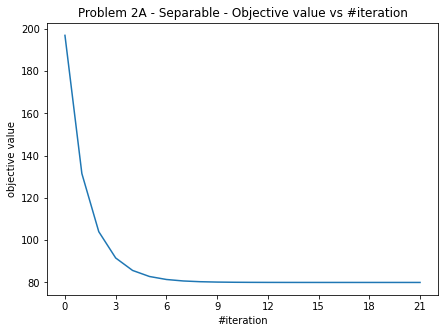

In [23]:
fig = plt.figure(figsize=(7,5))
plt.plot(range(len(prob_vals)), prob_vals)
ax = fig.gca()
plt.title("Problem 2A - Separable - Objective value vs #iteration")
plt.xlabel("#iteration")
plt.ylabel("objective value")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [10]:
u_opt = u_curr
v_opt = v_curr

A_opt = np.matmul(A, u_opt)
B_opt = np.matmul(B, v_opt)

gamma = 0.5*(np.linalg.norm(A_opt)**2-np.linalg.norm(B_opt)**2)
normal_vector = A_opt - B_opt
normal_vector = normal_vector

x_lin = np.linspace(-5, 5, 500)
y_lin = (-x_lin*normal_vector[0][0] + gamma)/normal_vector[1][0]

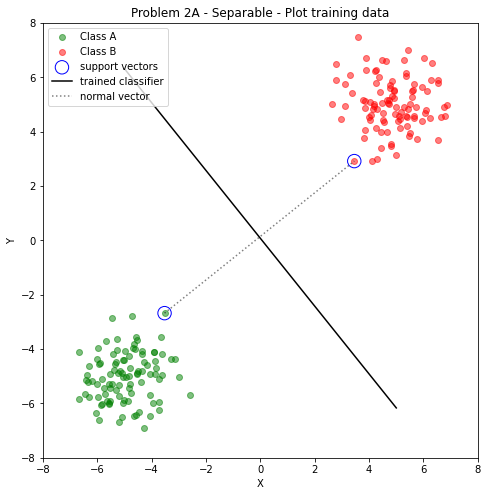

In [11]:
fig = plt.figure(figsize=(8,8))
plt.scatter(A[0,:],A[1,:], alpha=0.5, color='g', label='Class A')
plt.scatter(B[0,:],B[1,:], alpha=0.5, color='r', label='Class B')

# plot optimal point
plt.scatter(A_opt[0], A_opt[1], alpha=1, s=180, facecolors='none', edgecolors='b', label='support vectors')
plt.scatter(B_opt[0], B_opt[1], alpha=1, s=180, facecolors='none', edgecolors='b')

# plot hyperplane
plt.plot(x_lin, y_lin, label='trained classifier', color='black')
plt.plot([A_opt[0], B_opt[0]], [A_opt[1], B_opt[1]], alpha=0.5, ls="dotted", label='normal vector', color='black')

plt.title("Problem 2A - Separable - Plot training data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="upper left")
ax = plt.gca()
ax.set_aspect('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

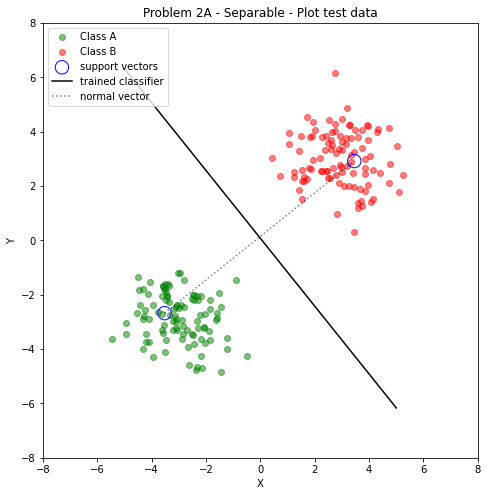

In [12]:
fig = plt.figure(figsize=(8,8))

plt.scatter(test[:,test_label==1][0,:],test[:,test_label==1][1,:], alpha=0.5, color='g', label='Class A')
plt.scatter(test[:,test_label==-1][0,:],test[:,test_label==-1][1,:], alpha=0.5, color='r', label='Class B')

# plot optimal point
plt.scatter(A_opt[0], A_opt[1], alpha=1, s=180, facecolors='none', edgecolors='b', label='support vectors')
plt.scatter(B_opt[0], B_opt[1], alpha=1, s=180, facecolors='none', edgecolors='b')

# plot hyperplane
plt.plot(x_lin, y_lin, label='trained classifier', color='black')
plt.plot([A_opt[0], B_opt[0]], [A_opt[1], B_opt[1]], alpha=0.5, ls="dotted", label='normal vector', color='black')

plt.title("Problem 2A - Separable - Plot test data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc="upper left")
ax = plt.gca()
ax.set_aspect('equal')
plt.xlim(-8, 8 )
plt.ylim(-8, 8 )
plt.show()